In [1]:
from abc import ABC, abstractmethod
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Interface for models
class MnistClassifierInterface(ABC):
    
    @abstractmethod
    def train(self, X_train, y_train):
        pass
    
    @abstractmethod
    def predict(self, X_test):
        pass

In [3]:
# 2. Random Forest Classifier
class RandomForestModel(MnistClassifierInterface):
    
    def __init__(self):
        self.model = RandomForestClassifier()
    
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test):
        return self.model.predict(X_test)

In [4]:
# 3. Feed-Forward Neural Network
class FeedForwardNeuralNetworkModel(MnistClassifierInterface):
    
    def __init__(self):
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )
        self.model = self.model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters())
    
    def train(self, X_train, y_train):
        X_train = torch.tensor(X_train, dtype=torch.float32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        y_train = torch.tensor(y_train, dtype=torch.long).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        
        self.model.train()
        for epoch in range(5):  # Train for 5 epochs
            for X_batch, y_batch in dataloader:
                self.optimizer.zero_grad()
                output = self.model(X_batch)
                loss = self.loss_fn(output, y_batch)
                loss.backward()
                self.optimizer.step()
    
    def predict(self, X_test):
        X_test = torch.tensor(X_test, dtype=torch.float32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        
        self.model.eval()
        with torch.no_grad():
            output = self.model(X_test)
        
        return torch.argmax(output, axis=1).cpu().numpy()

In [5]:
# 4. Convolutional Neural Network
class ConvolutionalNeuralNetworkModel(MnistClassifierInterface):
    
    def __init__(self):
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )
        self.model = self.model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters())
    
    def train(self, X_train, y_train):
        X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        y_train = torch.tensor(y_train, dtype=torch.long).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        
        self.model.train()
        for epoch in range(5):  # Train for 5 epochs
            for X_batch, y_batch in dataloader:
                self.optimizer.zero_grad()
                output = self.model(X_batch)
                loss = self.loss_fn(output, y_batch)
                loss.backward()
                self.optimizer.step()
    
    def predict(self, X_test):
        X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        
        self.model.eval()
        with torch.no_grad():
            output = self.model(X_test)
        
        return torch.argmax(output, axis=1).cpu().numpy()

In [6]:
# 5. MnistClassifier Class
class MnistClassifier:
    
    def __init__(self, algorithm: str):
        if algorithm == "rf":
            self.model = RandomForestModel()
        elif algorithm == "nn":
            self.model = FeedForwardNeuralNetworkModel()
        elif algorithm == "cnn":
            self.model = ConvolutionalNeuralNetworkModel()
        else:
            raise ValueError("Unsupported algorithm. Choose from: 'rf', 'nn', 'cnn'")
    
    def train(self, X_train, y_train):
        self.model.train(X_train, y_train)
    
    def predict(self, X_test):
        return self.model.predict(X_test)

In [7]:
# 6. Load and preprocess the MNIST dataset
def load_and_preprocess_data():

    # Fetch the MNIST dataset for RF
    mnist = fetch_openml('mnist_784', version=1, parser='auto')
    X = np.array(mnist.data)
    y = np.array(mnist.target.astype(int))

    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fetch the MNIST dataset for FFNN and CNN
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Normalize to range [-1, 1]
    
    train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    X_train, y_train = train_data.data.numpy(), train_data.targets.numpy()
    X_test, y_test = test_data.data.numpy(), test_data.targets.numpy()
    
    # Normalize the data to [0,1]
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    return X_train_rf, X_test_rf, y_train_rf, y_test_rf, X_train, y_train, X_test, y_test

In [8]:
# Function to build and plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    # Plotting the confusion matrix using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [9]:
# 7. Test the models
def test_model(algorithm: str):
    X_train_rf, X_test_rf, y_train_rf, y_test_rf, X_train, y_train, X_test, y_test = load_and_preprocess_data()

    # Choose the correct X, y based on model type
    if algorithm == 'rf':
        X_train = X_train_rf
        X_test = X_test_rf
        y_train = y_train_rf
        y_test = y_test_rf
    elif algorithm == 'nn' or algorithm == 'cnn':
        X_train = X_train
        X_test = X_test
        y_train = y_train
        y_test = y_test

    # Initialize the MnistClassifier
    classifier = MnistClassifier(algorithm)
    
    # Train the model
    classifier.train(X_train, y_train)
    
    # Predict with the model
    y_pred = classifier.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {algorithm}: {accuracy * 100:.2f}%")

    # Plot the confusion matrix RF
    class_names = [str(i) for i in range(10)]  # Assuming the target labels are 0-9
    plot_confusion_matrix(y_test, y_pred, class_names)

In [10]:
# Function for setting the seed
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    else: np.random.seed(seed)

In [11]:
set_seed(42)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.23MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.95MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Accuracy of rf: 96.76%


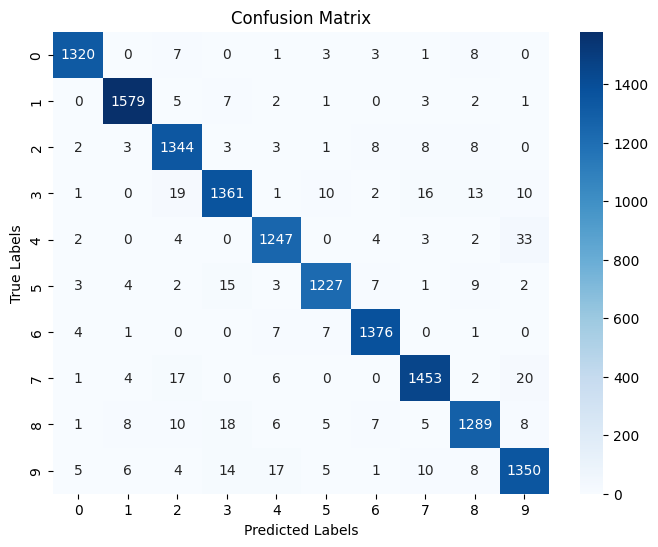

Accuracy of nn: 97.42%


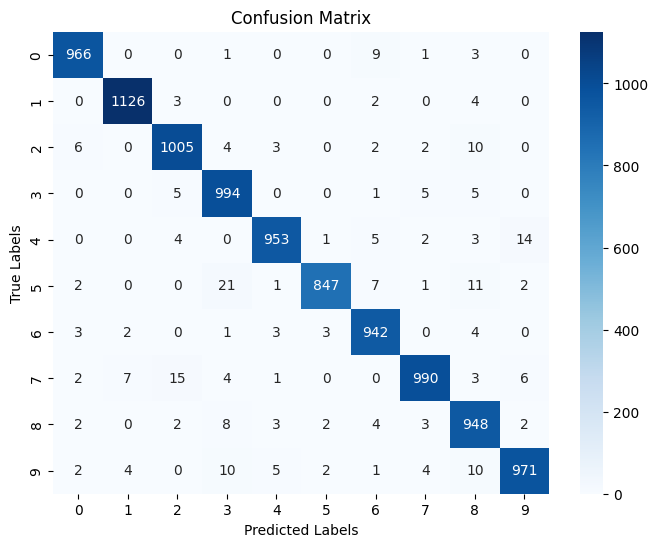

Accuracy of cnn: 99.16%


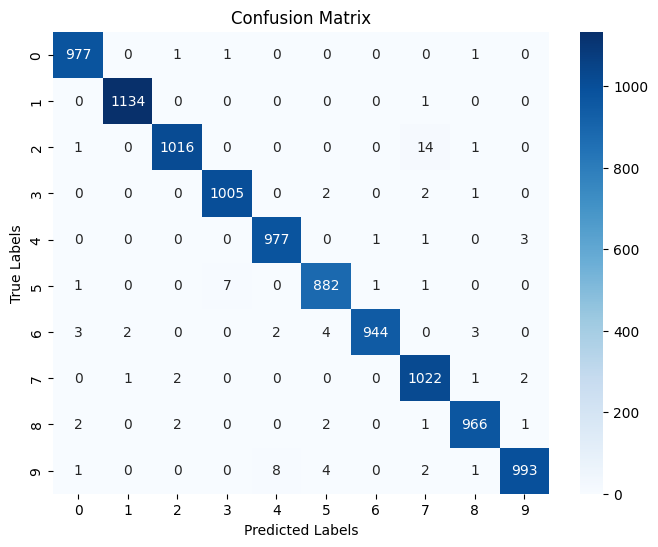

In [12]:
# Example of testing all three models
if __name__ == "__main__":
    for algorithm in ['rf','nn', 'cnn']:
        test_model(algorithm)